# Injection missteering: beam clone of operational BCMS (3bp) using single bunch with nominal skews settings

- hopefully this time with BPM logging on


In [1]:
%run /eos/project/m/mte/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.08.30_bunched
Your IP is 172.17.0.18
2018-03-08 15:13:59
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools


In [2]:
# let's start with the matlab data
files = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/data/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 120 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/data/2017.08.30.20.33.31.773.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/data/2017.08.30.21.55.57.969.mat


In [3]:
# let's start with the matlab data
files_unbunched = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_debunched_nominal_skews/data/2017*.mat'))
print 'Found ' + str(len(files_unbunched)) + ' data files'
print 'First: ' + files_unbunched[0]
print 'End: ' + files_unbunched[-1]

Found 120 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_debunched_nominal_skews/data/2017.08.30.22.49.57.953.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_debunched_nominal_skews/data/2017.08.31.00.06.17.148.mat


## Load the data

In [4]:
myDataFrame_bunched = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1','PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.AQN1.value',
                                                    'PI_KFA45.CCV.value'],verbose=False)

In [5]:
myDataFrame_unbunched = myToolbox.fromMatlabToDataFrame(files_unbunched,['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1','PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.AQN1.value',
                                                    'PI_KFA45.CCV.value'],verbose=False)

In [6]:
shiftVal=1
# plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')

# Tomogram
## Bunched case

In [7]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [9]:
# new tomogram analysis
files_tomo=sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/*.dat'))

# del(files_tomo[159])

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_500.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_501.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_502.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_503.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_504.dat
/eos/project/l/liu/Instrumentation/tomography/runo

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: loadtxt: Empty input file: "/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_513/d001.data"



IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_514.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_515.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_516.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_517.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_518.dat
/eos/project/l/liu/Instrumentation/tomog

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_558.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_559.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_560.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_561.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_562.dat
/eos/project/l/liu/Instrumentation/tomography/runo

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_602.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_603.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_604.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_605.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.30_bcms_bunched_nominal_skews/tomo_data/autosave_606.dat
/eos/project/l/liu/Instrumentation/tomography/runo

In [12]:
timeTolerance = 5

# ---------- Vars initialisation
myDataFrame_bunched['tomoTimestamp']=np.nan
myDataFrame_bunched['tomoDelta']=np.nan
myDataFrame_bunched['tomoFilename']=np.str
myDataFrame_bunched['deltaP_P_rms']=np.nan
myDataFrame_bunched['peakLineDensity']=np.nan
myDataFrame_bunched['beta']=np.nan
myDataFrame_bunched['gamma']=np.nan
myDataFrame_bunched['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame_bunched)
myDataFrame_bunched['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame_bunched)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame_bunched)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame_bunched['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame_bunched['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame_bunched['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame_bunched['tomoDelta'].iloc[x] = d
            myDataFrame_bunched['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame_bunched['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame_bunched['beta'].iloc[x]= betar
            myDataFrame_bunched['gamma'].iloc[x]= gammar
            myDataFrame_bunched['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame_bunched['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame_bunched)) 

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


117/129 are within the timeTolerance
length of dataframe is: 120


## Unbunched beams

In [14]:
myDataFrame_unbunched['deltaP_P_rms']=8.86e-4
myDataFrame_unbunched['peakLineDensity']=1.21

## Wire scanner

### X plane

In [15]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame_bunched['BWS65_position'] = myDataFrame_bunched['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame_bunched['BWS65_position_idx'] = myDataFrame_bunched['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [16]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame_unbunched['BWS65_position'] = myDataFrame_unbunched['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame_unbunched['BWS65_position_idx'] = myDataFrame_unbunched['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [17]:
#instantiate an array object for the result in the frame
myDataFrame_bunched['BWS65_data'] = myDataFrame_bunched['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame_bunched.shape

for r in xrange(row):
    myDataFrame_bunched['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame_bunched['BWS65_position'].iloc[r], myDataFrame_bunched['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame_bunched['BWS65_position_idx'].iloc[r]])  

In [18]:
#instantiate an array object for the result in the frame
myDataFrame_unbunched['BWS65_data'] = myDataFrame_unbunched['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame_unbunched.shape

for r in xrange(row):
    myDataFrame_unbunched['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame_unbunched['BWS65_position'].iloc[r], myDataFrame_unbunched['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame_unbunched['BWS65_position_idx'].iloc[r]])  

In [19]:
#do the fit and get the sigma in mm
myDataFrame_bunched['WS_fit_results_x'] = myDataFrame_bunched['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame_bunched['WS_sigma_x'] = myDataFrame_bunched['WS_fit_results_x'].apply(lambda x: x[0][-1])

In [20]:
#do the fit and get the sigma in mm
myDataFrame_unbunched['WS_fit_results_x'] = myDataFrame_unbunched['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame_unbunched['WS_sigma_x'] = myDataFrame_unbunched['WS_fit_results_x'].apply(lambda x: x[0][-1])

### Y plane

In [21]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame_bunched['BWS85_position'] = myDataFrame_bunched['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame_bunched['BWS85_position_idx'] = myDataFrame_bunched['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [22]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame_unbunched['BWS85_position'] = myDataFrame_unbunched['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame_unbunched['BWS85_position_idx'] = myDataFrame_unbunched['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [23]:
#instantiate an array object for the result in the frame
myDataFrame_bunched['BWS85_data'] = myDataFrame_bunched['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame_bunched.shape

for r in xrange(row):
    myDataFrame_bunched['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame_bunched['BWS85_position'].iloc[r], myDataFrame_bunched['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame_bunched['BWS85_position_idx'].iloc[r]])  

In [24]:
#instantiate an array object for the result in the frame
myDataFrame_unbunched['BWS85_data'] = myDataFrame_unbunched['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame_unbunched.shape

for r in xrange(row):
    myDataFrame_unbunched['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame_unbunched['BWS85_position'].iloc[r], myDataFrame_unbunched['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame_unbunched['BWS85_position_idx'].iloc[r]])  

In [25]:
#do the fit and get the sigma in mm
myDataFrame_bunched['WS_fit_results_y'] = myDataFrame_bunched['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame_bunched['WS_sigma_y'] = myDataFrame_bunched['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [26]:
#do the fit and get the sigma in mm
myDataFrame_unbunched['WS_fit_results_y'] = myDataFrame_unbunched['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame_unbunched['WS_sigma_y'] = myDataFrame_unbunched['WS_fit_results_y'].apply(lambda x: x[0][-1])

## Emitance

In [27]:
def normalised_emittance(sig, dp):
    "Calculate the normalised emittance, where sig is in mm. dp is DeltaP/P rms"
    betar = 0.915095 
#     D = 2.330216464 #at wirescanner 68
    D = 3.24577470 #at wirescanner 65
#     betax = 13.00860302 #at wirescanner 68
    betax = 21.77988929 #at wirescanner 65
#     betax = 20.11 #at wirescanner 65

    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    return emi*1e6

def normalised_emittance_y(sig):
    "Calculate the normalised emittance without the dispesive component"
    betar = 0.915095
    betay = 11.44763004 #[metres] #at wirescanner 85
#     betay = 12.35
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2)/betay *(betar*gammar)
    return emi*1e6
    

### Y plane

In [28]:
myDataFrame_bunched['WS_emittance_y'] = myDataFrame_bunched['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

In [29]:
myDataFrame_unbunched['WS_emittance_y'] = myDataFrame_unbunched['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

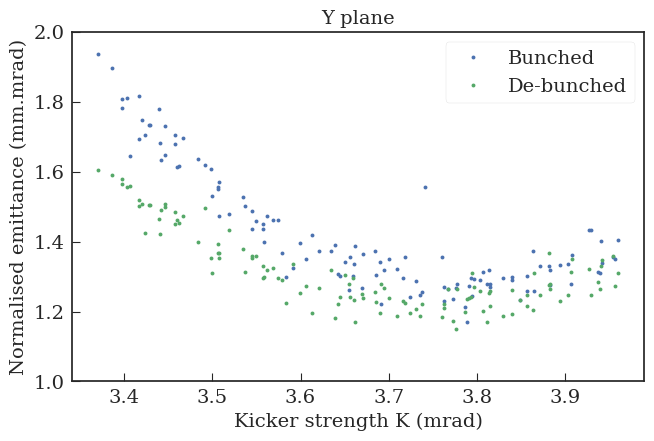

In [58]:
#bunched
fig, ax = plt.subplots(1)
fig.dpi=100

ax.plot(1e3*myDataFrame_bunched['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame_bunched['WS_emittance_y'],'.', label='Bunched')
ax.plot(1e3*myDataFrame_unbunched['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame_unbunched['WS_emittance_y'],'.', label='De-bunched')

ax.set_xlabel('Kicker strength K (mrad)')
ax.set_ylabel('Normalised emittance (mm.mrad)')

ax.set_

plt.title('Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2))
plt.legend(frameon=True)
plt.show()

fig.savefig('Y_emi_b_db.pdf', format='pdf',dpi=1000)

### X plane

In [46]:
myDataFrame_bunched['WS_emittance_x'] = np.nan

for n in range(len(myDataFrame_bunched)):
    myDataFrame_bunched['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame_bunched['WS_sigma_x'].values[n],myDataFrame_bunched['deltaP_P_rms'].values[n])

In [47]:
myDataFrame_unbunched['WS_emittance_x'] = np.nan

for n in range(len(myDataFrame_unbunched)):
    myDataFrame_unbunched['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame_unbunched['WS_sigma_x'].values[n],myDataFrame_unbunched['deltaP_P_rms'].values[n])

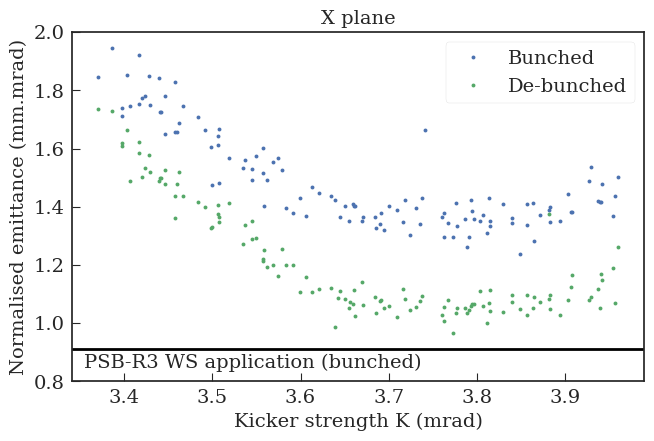

In [59]:
#bunched
fig, ax = plt.subplots(1)
fig.dpi=100
ax.plot(1e3*myDataFrame_bunched['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame_bunched['WS_emittance_x'],'.', label='Bunched')
ax.plot(1e3*myDataFrame_unbunched['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame_unbunched['WS_emittance_x'],'.', label='De-bunched')

ax.set_xlabel('Kicker strength K (mrad)')
ax.set_ylabel('Normalised emittance (mm.mrad)')

ax.set_title('X plane')

plt.axhline(y=0.91, linewidth=2, color='k')
plt.text(0.02, 0.08, 'PSB-R3 WS application (bunched)',
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.8,2))
ax.legend(frameon=True)
plt.show()

fig.savefig('X_emi_b_db.pdf', format='pdf',dpi=1000)